In [1]:
import zipfile
with zipfile.ZipFile('./skin-cancer-malignant-vs-benign.zip','r') as zip_ref:
    zip_ref.extractall('./skin_cancer_MobileNet')

In [2]:
import os 
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree as plot_tree
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

2022-10-13 00:28:04.411280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 00:28:04.724485: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-13 00:28:04.724548: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-13 00:28:04.798334: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-13 00:28:06.506755: W tensorflow/stream_executor/pla

In [3]:
modelo_pt2 = MobileNet(
    weights ='imagenet',
    input_shape=(224,224,3),
    include_top=False
)
modelo_pt2.summary()

2022-10-13 00:28:08.742575: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-13 00:28:08.742640: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-13 00:28:08.742683: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-10-13 00:28:08.743093: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [4]:
modelo2 = Sequential()
modelo2.add(modelo_pt2)
modelo2.add(GlobalAveragePooling2D())
modelo2.add(Dense(4096, activation='relu'))
modelo2.add(Dropout(0.5))
modelo2.add(Dense(4096, activation='relu'))
modelo2.add(Dropout(0.5))
modelo2.add(Dense(1, activation='sigmoid'))

modelo2.layers[0].trainable = False
modelo2.compile(optimizer=Adam(0.0001, epsilon=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

modelo2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4096)              4198400   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0

In [ ]:
# train_datagen = ImageDataGenerator(
#     preprocessing_function = preprocess_input,
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

train_datagen_aug = ImageDataGenerator(rescale=1.0/255.0,
                                       zoom_range = 0.2,
                                       vertical_flip = True , 
                                       rotation_range=40,
                                       horizontal_flip = True)

# validation_datagen = ImageDataGenerator(
#     preprocessing_function = preprocess_input,
#     rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

test_datagen_aug = ImageDataGenerator(rescale=1.0/ 255.0,validation_split=1./3)

train_generator = train_datagen_aug.flow_from_directory(
    os.path.join('skin_cancer_MobileNet','train'),
    target_size=(224, 224),
    class_mode='binary'
)

validation_generator = test_datagen_aug.flow_from_directory(
    os.path.join('skin_cancer_MobileNet','test'),
    target_size=(224, 224),
    class_mode='binary'
)

modelo2.compile(loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])

history = modelo2.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator
)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Epoch 1/50
83/83 [==============================] - 188s 2s/step - loss: 2.6415 - accuracy: 0.7057 - val_loss: 0.3784 - val_accuracy: 0.8182
Epoch 2/50
83/83 [==============================] - 181s 2s/step - loss: 0.5145 - accuracy: 0.7937 - val_loss: 0.3868 - val_accuracy: 0.8621
Epoch 3/50
83/83 [==============================] - 178s 2s/step - loss: 0.4580 - accuracy: 0.8081 - val_loss: 0.6284 - val_accuracy: 0.7788
Epoch 4/50
83/83 [==============================] - 179s 2s/step - loss: 0.4312 - accuracy: 0.8199 - val_loss: 0.3651 - val_accuracy: 0.8455
Epoch 5/50
83/83 [==============================] - 160s 2s/step - loss: 0.4114 - accuracy: 0.8290 - val_loss: 0.3270 - val_accuracy: 0.8712
Epoch 6/50
83/83 [==============================] - 178s 2s/step - loss: 0.3908 - accuracy: 0.8309 - val_loss: 0.3908 - val_accuracy: 0.8136
Epoch 7/50
83/83 [==============================] - 123s 1s/step - loss

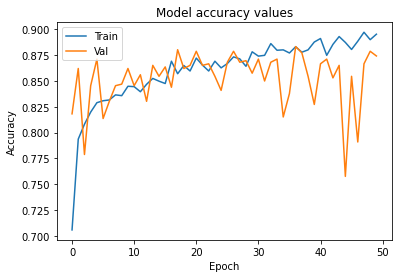

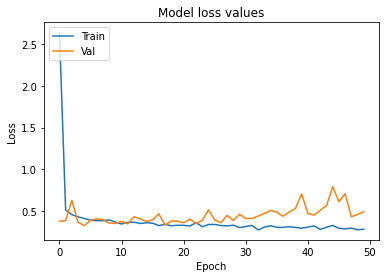

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()